# Digital acceptance testing

Goal is to make it easy to modify f-eng configuration while recording data.

1. Write MS file
- set all inputs to zeros
- set pol a inputs to adc, then pol b to adc
- set eq coeffs to zero for first ten channels on first snap, then iterate through all snaps

2. Write beamformed data
- set inputs to zeros
- set pol a inputs to adc, then pol b to adc
- set eq coeffs to zero for first ten channels on first snap, then iterate through all snaps
3. Read autos from MS file
- confirm order of zeros, adc on pol on sequence, channel off sequence, and antennas off sequence
4. Read beamformed data
- confirm order of zeros, adc on pol order, channel off order by channel

### Setup

In [1]:
%matplotlib inline

In [2]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from matplotlib import animation
from matplotlib import pyplot as plt
from IPython.display import Image

from mnc import control
from lwa_f import snap2_fengine, snap2_feng_etcd_client
from lwa_antpos import mapping
import casacore.tables
from retry import retry

Read antpos from etcd


In [3]:
from bokeh.layouts import column, row
from bokeh.models import ColumnDataSource, DataRange1d, Select
from bokeh.palettes import Viridis
from bokeh.plotting import figure
from bokeh.io import show, output_notebook

output_notebook()

Loading BokehJS ...

In [4]:
snap2names = [f'snap{i:02}' for i in range(1, 12)]

def set_input(mode='use_zero', stream=None, pol=None, names=snap2names):
    """ Set the input block method
    mode can be "use_zero", "use_adc", "use_noise", "zero_coeffs",
    "reset_coeffs", "get_status".
    """

    if isinstance(names, str):
        names = [names]

    for name in names:
        f = snap2_fengine.Snap2Fengine(name)
        num = int(name.lstrip('snap'))

        if (pol is None) or isinstance(stream, int):
            print(f"Set stream: {stream}")
            run(f, stream, mode=mode)
        elif (stream is None) and (pol is not None):
            antpols = []
            if pol == 'a':
                inps = list(range(0,64,2))
            elif pol == 'b':
                inps = list(range(1,64,2))
            for inp in inps:
                antpols.append(mapping.snap2_to_antpol(num, inp))
                run(f, inp, mode=mode)
            print(f"Set antpols {antpols}")

@retry(RuntimeError, tries=2)
def run(f, stream, mode='use_zero', zerochans=range(0, 5)):
    if mode == 'use_zero':
        f.input.use_zero(stream)
    elif mode == 'use_adc':
        f.input.use_adc(stream)
    elif mode == 'use_noise':
        f.input.use_noise(stream)
    elif mode == 'get_status':
        print('input status:')
        f.input.get_status()
        print('eqtvg status:')
        f.eqtvg.get_status()
    elif mode == 'reset_coeffs':
        f.eq.initialize(read_only=False)
    elif mode == 'zero_coeffs':
        for i in range(64):
            coeffs, scalefactor = f.eq.get_coeffs(i)
            # [1] is scale factor (coeff binary point), coeff = 9600/2**scalefactor?
            coeffs2 = coeffs >> zeropoint
            coeffs2[:5] = 0
            f.eq.set_coeffs(i, coeffs=coeffs2)
    else:
        print(f'mode {mode} not recognized')
# or
#        f.eqtvg.tvg_enable()
#        f.eqtvg.write_stream_tvg()
#        f.eqtvg.write_const_per_stream()
#        f.eqtvg.write_freq_ramp()

def plot_autospecs(names=snap2names, ret=False, bokeh=True):
    """ plots auto correlations for sets of snap2names.
    Can optionally return array with ret=True.
    """

    if isinstance(names, str):
        names = [names]

    autospecs = []
    for name in names:
        f = snap2_fengine.Snap2Fengine(name)
        for i in range(64):
            spec = f.corr.get_new_corr(i, i).real  # 8-channel average, normalized by accumulated time/chans
            autospecs.append(spec)
    autospecs = np.vstack(autospecs)

    if bokeh:
        TOOLTIPS = [("x", "$x"), ("y", "$y"), ("value", "@image")]
        plot = figure(plot_width=800, plot_height=400, tooltips=TOOLTIPS)
        _ = plot.image(image=[autospecs], x=0, y=0, dw=512, dh=len(autospecs), palette=Viridis[4])
        plot.xaxis.axis_label = 'Channel (8-chan avg)'
        plot.yaxis.axis_label = 'Input (64 per snap, stacked)'
        show(plot)
    else:
        fig, (ax0) = plt.subplots(1, 1, figsize=(12,12))
        ax0.imshow(autospecs, origin='lower', interpolation='nearest')

    if ret:
        return autospecs

In [5]:
con = control.Controller("/home/pipeline/proj/lwa-shell/mnc_python/config/lwa_config_calim.yaml")

DEBUG:Got command response
DEBUG:Response: {'id': '1667495654080192', 'val': {'status': 'normal', 'response': 1589222, 'timestamp': 1667495654.0867126}}
DEBUG:Got command response
DEBUG:Response: {'id': '1667495654089802', 'val': {'status': 'normal', 'response': 1589223, 'timestamp': 1667495654.095255}}
DEBUG:Got command response
DEBUG:Response: {'id': '1667495654098825', 'val': {'status': 'normal', 'response': 1589224, 'timestamp': 1667495654.1043694}}
DEBUG:Got command response
DEBUG:Response: {'id': '1667495654107521', 'val': {'status': 'normal', 'response': 1589225, 'timestamp': 1667495654.1124053}}
DEBUG:Got command response
DEBUG:Response: {'id': '1667495654114641', 'val': {'status': 'normal', 'response': 15835, 'timestamp': 1667495654.1191223}}
DEBUG:Got command response
DEBUG:Response: {'id': '1667495654122642', 'val': {'status': 'normal', 'response': 15836, 'timestamp': 1667495654.132573}}
DEBUG:Got command response
DEBUG:Response: {'id': '1667495654135568', 'val': {'status': 

Loaded configuration for 8 x-engine host(s) running 4 pipeline(s) each
Supported modes are: slow,beam1,beam2,beam3,beam4,beam5,beam6,beam7,beam8
etcd server being used is: etcdv3service


In [6]:
con.start_fengine()

2022-11-03 17:14:22,061 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 0
2022-11-03 17:14:22,695 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 1
snap01 is already connected.
2022-11-03 17:14:24,040 - lwa_f.blocks.block:snap02 - INFO - adc - Detected FMC ADC board on port 0
2022-11-03 17:14:24,871 - lwa_f.blocks.block:snap02 - INFO - adc - Detected FMC ADC board on port 1
snap02 is already connected.
2022-11-03 17:14:26,089 - lwa_f.blocks.block:snap03 - INFO - adc - Detected FMC ADC board on port 0
2022-11-03 17:14:26,812 - lwa_f.blocks.block:snap03 - INFO - adc - Detected FMC ADC board on port 1
snap03 is already connected.
2022-11-03 17:14:28,238 - lwa_f.blocks.block:snap04 - INFO - adc - Detected FMC ADC board on port 0
2022-11-03 17:14:28,864 - lwa_f.blocks.block:snap04 - INFO - adc - Detected FMC ADC board on port 1
snap04 is already connected.
2022-11-03 17:14:33,075 - lwa_f.blocks.block:snap05 - INFO - adc - Detected FMC ADC 

In [12]:
con.stop_xengine()
con.start_xengine()

2022-11-03 17:45:30 [INFO    ] Pipelines all appear to be ready after 17.4 seconds


INFO:Pipelines all appear to be ready after 17.4 seconds
INFO:pipelines up? True


pipelines up? True
Configuring x-engine for slow visibilities
2022-11-03 17:45:30 [INFO    ] Setting max data output rate per pipeline to 625.0 Mbit/s


INFO:Setting max data output rate per pipeline to 625.0 Mbit/s


2022-11-03 17:45:30 [INFO    ] Setting pipeline lxdlwagpu01:0 data destination to 10.41.0.76:10001


INFO:Setting pipeline lxdlwagpu01:0 data destination to 10.41.0.76:10001


2022-11-03 17:45:30 [INFO    ] Setting pipeline lxdlwagpu01:1 data destination to 10.41.0.76:10001


INFO:Setting pipeline lxdlwagpu01:1 data destination to 10.41.0.76:10001


2022-11-03 17:45:30 [INFO    ] Setting pipeline lxdlwagpu01:2 data destination to 10.41.0.76:10002


INFO:Setting pipeline lxdlwagpu01:2 data destination to 10.41.0.76:10002


2022-11-03 17:45:30 [INFO    ] Setting pipeline lxdlwagpu01:3 data destination to 10.41.0.76:10002


INFO:Setting pipeline lxdlwagpu01:3 data destination to 10.41.0.76:10002


2022-11-03 17:45:31 [INFO    ] Setting pipeline lxdlwagpu02:0 data destination to 10.41.0.77:10001


INFO:Setting pipeline lxdlwagpu02:0 data destination to 10.41.0.77:10001


2022-11-03 17:45:31 [INFO    ] Setting pipeline lxdlwagpu02:1 data destination to 10.41.0.77:10001


INFO:Setting pipeline lxdlwagpu02:1 data destination to 10.41.0.77:10001


2022-11-03 17:45:31 [INFO    ] Setting pipeline lxdlwagpu02:2 data destination to 10.41.0.77:10002


INFO:Setting pipeline lxdlwagpu02:2 data destination to 10.41.0.77:10002


2022-11-03 17:45:31 [INFO    ] Setting pipeline lxdlwagpu02:3 data destination to 10.41.0.77:10002


INFO:Setting pipeline lxdlwagpu02:3 data destination to 10.41.0.77:10002


2022-11-03 17:45:31 [INFO    ] Setting pipeline lxdlwagpu03:0 data destination to 10.41.0.78:10001


INFO:Setting pipeline lxdlwagpu03:0 data destination to 10.41.0.78:10001


2022-11-03 17:45:31 [INFO    ] Setting pipeline lxdlwagpu03:1 data destination to 10.41.0.78:10001


INFO:Setting pipeline lxdlwagpu03:1 data destination to 10.41.0.78:10001


2022-11-03 17:45:31 [INFO    ] Setting pipeline lxdlwagpu03:2 data destination to 10.41.0.78:10002


INFO:Setting pipeline lxdlwagpu03:2 data destination to 10.41.0.78:10002


2022-11-03 17:45:31 [INFO    ] Setting pipeline lxdlwagpu03:3 data destination to 10.41.0.78:10002


INFO:Setting pipeline lxdlwagpu03:3 data destination to 10.41.0.78:10002


2022-11-03 17:45:31 [INFO    ] Setting pipeline lxdlwagpu04:0 data destination to 10.41.0.79:10001


INFO:Setting pipeline lxdlwagpu04:0 data destination to 10.41.0.79:10001


2022-11-03 17:45:31 [INFO    ] Setting pipeline lxdlwagpu04:1 data destination to 10.41.0.79:10001


INFO:Setting pipeline lxdlwagpu04:1 data destination to 10.41.0.79:10001


2022-11-03 17:45:31 [INFO    ] Setting pipeline lxdlwagpu04:2 data destination to 10.41.0.79:10002


INFO:Setting pipeline lxdlwagpu04:2 data destination to 10.41.0.79:10002


2022-11-03 17:45:31 [INFO    ] Setting pipeline lxdlwagpu04:3 data destination to 10.41.0.79:10002


INFO:Setting pipeline lxdlwagpu04:3 data destination to 10.41.0.79:10002


2022-11-03 17:45:31 [INFO    ] Setting pipeline lxdlwagpu05:0 data destination to 10.41.0.80:10001


INFO:Setting pipeline lxdlwagpu05:0 data destination to 10.41.0.80:10001


2022-11-03 17:45:31 [INFO    ] Setting pipeline lxdlwagpu05:1 data destination to 10.41.0.80:10001


INFO:Setting pipeline lxdlwagpu05:1 data destination to 10.41.0.80:10001


2022-11-03 17:45:31 [INFO    ] Setting pipeline lxdlwagpu05:2 data destination to 10.41.0.80:10002


INFO:Setting pipeline lxdlwagpu05:2 data destination to 10.41.0.80:10002


2022-11-03 17:45:31 [INFO    ] Setting pipeline lxdlwagpu05:3 data destination to 10.41.0.80:10002


INFO:Setting pipeline lxdlwagpu05:3 data destination to 10.41.0.80:10002


2022-11-03 17:45:31 [INFO    ] Setting pipeline lxdlwagpu06:0 data destination to 10.41.0.81:10001


INFO:Setting pipeline lxdlwagpu06:0 data destination to 10.41.0.81:10001


2022-11-03 17:45:31 [INFO    ] Setting pipeline lxdlwagpu06:1 data destination to 10.41.0.81:10001


INFO:Setting pipeline lxdlwagpu06:1 data destination to 10.41.0.81:10001


2022-11-03 17:45:31 [INFO    ] Setting pipeline lxdlwagpu06:2 data destination to 10.41.0.81:10002


INFO:Setting pipeline lxdlwagpu06:2 data destination to 10.41.0.81:10002


2022-11-03 17:45:31 [INFO    ] Setting pipeline lxdlwagpu06:3 data destination to 10.41.0.81:10002


INFO:Setting pipeline lxdlwagpu06:3 data destination to 10.41.0.81:10002


2022-11-03 17:45:31 [INFO    ] Setting pipeline lxdlwagpu07:0 data destination to 10.41.0.82:10001


INFO:Setting pipeline lxdlwagpu07:0 data destination to 10.41.0.82:10001


2022-11-03 17:45:31 [INFO    ] Setting pipeline lxdlwagpu07:1 data destination to 10.41.0.82:10001


INFO:Setting pipeline lxdlwagpu07:1 data destination to 10.41.0.82:10001


2022-11-03 17:45:31 [INFO    ] Setting pipeline lxdlwagpu07:2 data destination to 10.41.0.82:10002


INFO:Setting pipeline lxdlwagpu07:2 data destination to 10.41.0.82:10002


2022-11-03 17:45:31 [INFO    ] Setting pipeline lxdlwagpu07:3 data destination to 10.41.0.82:10002


INFO:Setting pipeline lxdlwagpu07:3 data destination to 10.41.0.82:10002


2022-11-03 17:45:31 [INFO    ] Setting pipeline lxdlwagpu08:0 data destination to 10.41.0.83:10001


INFO:Setting pipeline lxdlwagpu08:0 data destination to 10.41.0.83:10001


2022-11-03 17:45:31 [INFO    ] Setting pipeline lxdlwagpu08:1 data destination to 10.41.0.83:10001


INFO:Setting pipeline lxdlwagpu08:1 data destination to 10.41.0.83:10001


2022-11-03 17:45:31 [INFO    ] Setting pipeline lxdlwagpu08:2 data destination to 10.41.0.83:10002


INFO:Setting pipeline lxdlwagpu08:2 data destination to 10.41.0.83:10002


2022-11-03 17:45:31 [INFO    ] Setting pipeline lxdlwagpu08:3 data destination to 10.41.0.83:10002


INFO:Setting pipeline lxdlwagpu08:3 data destination to 10.41.0.83:10002


2022-11-03 17:45:31 [INFO    ] Arming correlator core


INFO:Arming correlator core


2022-11-03 17:45:33 [INFO    ] All pipelines in 'waiting' state as expected


INFO:All pipelines in 'waiting' state as expected


2022-11-03 17:45:33 [INFO    ] Waiting 10 seconds for trigger


INFO:Waiting 10 seconds for trigger


2022-11-03 17:45:43 [INFO    ] All pipelines in 'running' state as expected


INFO:All pipelines in 'running' state as expected


2022-11-03 17:45:43 [INFO    ] Arming correlator accumulator core


INFO:Arming correlator accumulator core


2022-11-03 17:45:44 [INFO    ] All pipelines in 'waiting' state as expected


INFO:All pipelines in 'waiting' state as expected


2022-11-03 17:45:44 [INFO    ] Waiting 10 seconds for trigger


INFO:Waiting 10 seconds for trigger


2022-11-03 17:45:54 [INFO    ] All pipelines in 'running' state as expected


INFO:All pipelines in 'running' state as expected


Not configuring x-engine for fast visibilities
Start power beams with "start_xengine_bf" method"


In [20]:
con.status_dr(['drvs', 'dr1', 'dr2'])

['14 recording; 0 idle; 2 timed out',
 'WARNING: drvs not fully operational: 3 sub-bands have not updated in 120 s: drvs7702,drvs8101,drvs8102',
 'idle',
 'idle']

In [18]:
con.start_dr(recorders=['drvs', 'dr1', 'dr2'], duration=30)

Starting recorders: ['drvs', 'dr1', 'dr2']
recording on dr1 for 0.030 s to file /data01/beam01/059886_174806723624a35ee27
recording on dr2 for 0.030 s to file /data01/beam02/059886_174806736674a360eb3


In [16]:
con.start_xengine_bf(num=1, calibrate=False)

Coordinates not fully specified. Pointing at zenith.
No calibration will be applied


/home/pipeline/.conda/envs/development/lib/python3.6/site-packages/mnc/xengine_beamformer_control.py:556: UserWarning: No calibration data found in '/pathshouldnotexist'
  warnings.warn(f"No calibration data found in '{cal_directory}'")
/home/pipeline/.conda/envs/development/lib/python3.6/site-packages/mnc/xengine_beamformer_control.py:351: UserWarning: Calibration is not set, your results may be suspect
  warnings.warn("Calibration is not set, your results may be suspect")


Not tracking for azel input


In [17]:
con.start_xengine_bf(num=2, calibrate=False)

Coordinates not fully specified. Pointing at zenith.
No calibration will be applied
Not tracking for azel input


In [22]:
con.stop_dr()

### Visualize initial state

In [ ]:
set_input(mode='use_adc')

In [ ]:
autospecs = plot_autospecs(ret=True)

### Observing sequence


In [20]:
tblock = 3*10  # seconds

set_input(mode='use_zero')
time.sleep(tblock)
set_input(mode='use_adc', pol='a')
time.sleep(tblock)
set_input(mode='use_adc', pol='b')
time.sleep(tblock)
#for name in snap2names:
#    set_input(mode='zero_coeffs', names=name) # zeros some channels
#    time.sleep(tblock)
set_input(mode='reset_coeffs')
time.sleep(tblock)
set_input(mode='use_zero')
time.sleep(tblock)
set_input(mode='use_adc')
time.sleep(tblock)

2022-06-01 11:32:33,601 - lwa_f.blocks.block:snap01 - WARNING -  - hostname (10.40.0.157) couldn't be turned into integer serial
2022-06-01 11:32:33,810 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 0
2022-06-01 11:32:34,023 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 1
Set stream: None
2022-06-01 11:32:34,511 - lwa_f.blocks.block:snap02 - WARNING -  - hostname (10.40.0.132) couldn't be turned into integer serial
2022-06-01 11:32:34,806 - lwa_f.blocks.block:snap02 - INFO - adc - Detected FMC ADC board on port 0
2022-06-01 11:32:35,085 - lwa_f.blocks.block:snap02 - INFO - adc - Detected FMC ADC board on port 1
Set stream: None
2022-06-01 11:32:35,615 - lwa_f.blocks.block:snap03 - WARNING -  - hostname (10.40.0.136) couldn't be turned into integer serial
2022-06-01 11:32:35,849 - lwa_f.blocks.block:snap03 - INFO - adc - Detected FMC ADC board on port 0
2022-06-01 11:32:36,055 - lwa_f.blocks.block:snap03 - INFO - adc - Detected FMC

2022-06-01 11:33:23,311 - lwa_f.blocks.block:snap07 - INFO - adc - Detected FMC ADC board on port 0
2022-06-01 11:33:23,524 - lwa_f.blocks.block:snap07 - INFO - adc - Detected FMC ADC board on port 1
Set antpols ['LWA-078A', 'LWA-076A', 'LWA-081A', 'LWA-079A', 'LWA-108A', 'LWA-107A', 'LWA-110A', 'LWA-109A', 'LWA-112A', 'LWA-111A', 'LWA-114A', 'LWA-113A', 'LWA-116A', 'LWA-115A', 'LWA-118A', 'LWA-117A', 'LWA-120A', 'LWA-082A', 'LWA-143A', 'LWA-142A', 'LWA-145A', 'LWA-144A', 'LWA-147A', 'LWA-150A', 'LWA-149A', 'LWA-148A', 'LWA-151A', 'LWA-172A', 'LWA-279A', 'LWA-178A', 'LWA-355A', 'LWA-287A']
2022-06-01 11:33:23,967 - lwa_f.blocks.block:snap08 - WARNING -  - hostname (10.40.0.188) couldn't be turned into integer serial
2022-06-01 11:33:24,179 - lwa_f.blocks.block:snap08 - INFO - adc - Detected FMC ADC board on port 0
2022-06-01 11:33:24,386 - lwa_f.blocks.block:snap08 - INFO - adc - Detected FMC ADC board on port 1
Set antpols ['LWA-124A', 'LWA-127A', 'LWA-126A', 'LWA-125A', 'LWA-188A', '

2022-06-01 11:34:04,070 - lwa_f.blocks.block:snap08 - WARNING -  - hostname (10.40.0.188) couldn't be turned into integer serial
2022-06-01 11:34:04,279 - lwa_f.blocks.block:snap08 - INFO - adc - Detected FMC ADC board on port 0
2022-06-01 11:34:04,483 - lwa_f.blocks.block:snap08 - INFO - adc - Detected FMC ADC board on port 1
Set antpols ['LWA-124B', 'LWA-127B', 'LWA-126B', 'LWA-125B', 'LWA-188B', 'LWA-128B', 'LWA-153B', 'LWA-152B', 'LWA-155B', 'LWA-154B', 'LWA-157B', 'LWA-156B', 'LWA-159B', 'LWA-158B', 'LWA-182B', 'LWA-160B', 'LWA-185B', 'LWA-184B', 'LWA-187B', 'LWA-186B', 'LWA-190B', 'LWA-189B', 'LWA-191B', 'LWA-192B', 'LWA-224B', 'LWA-222B', 'LWA-326B', 'LWA-322B', 'LWA-345B', 'LWA-333B', 'LWA-359B', 'LWA-347B']
2022-06-01 11:34:04,943 - lwa_f.blocks.block:snap09 - WARNING -  - hostname (10.40.0.124) couldn't be turned into integer serial
2022-06-01 11:34:05,209 - lwa_f.blocks.block:snap09 - INFO - adc - Detected FMC ADC board on port 0
2022-06-01 11:34:05,474 - lwa_f.blocks.block:

2022-06-01 11:35:26,300 - lwa_f.blocks.block:snap05 - INFO - adc - Detected FMC ADC board on port 0
2022-06-01 11:35:26,586 - lwa_f.blocks.block:snap05 - INFO - adc - Detected FMC ADC board on port 1
Set stream: None
2022-06-01 11:35:27,088 - lwa_f.blocks.block:snap06 - WARNING -  - hostname (10.40.0.131) couldn't be turned into integer serial
2022-06-01 11:35:27,306 - lwa_f.blocks.block:snap06 - INFO - adc - Detected FMC ADC board on port 0
2022-06-01 11:35:27,586 - lwa_f.blocks.block:snap06 - INFO - adc - Detected FMC ADC board on port 1
Set stream: None
2022-06-01 11:35:28,111 - lwa_f.blocks.block:snap07 - WARNING -  - hostname (10.40.0.129) couldn't be turned into integer serial
2022-06-01 11:35:28,371 - lwa_f.blocks.block:snap07 - INFO - adc - Detected FMC ADC board on port 0
2022-06-01 11:35:28,598 - lwa_f.blocks.block:snap07 - INFO - adc - Detected FMC ADC board on port 1
Set stream: None
2022-06-01 11:35:29,065 - lwa_f.blocks.block:snap08 - WARNING -  - hostname (10.40.0.188) c

In [21]:
con.stop_dr()
con.stop_xengine()

Found 16 slow recorders: drvs2501 drvs2502 drvs2503 drvs2504 drvs2505 drvs2506 drvs2507 drvs2508 drvs7301 drvs7302 drvs7303 drvs7304 drvs7305 drvs7306 drvs7307 drvs7308


DEBUG:Got command response
DEBUG:Response: {'id': '1654108776699602', 'val': {'status': 'normal', 'response': 9577, 'timestamp': 1654108776.7068913}}
DEBUG:Got command response
DEBUG:Response: {'id': '1654108776715841', 'val': {'status': 'normal', 'response': 9579, 'timestamp': 1654108776.723918}}
DEBUG:Got command response
DEBUG:Response: {'id': '1654108776727596', 'val': {'status': 'normal', 'response': 9580, 'timestamp': 1654108776.7367353}}
DEBUG:Got command response
DEBUG:Response: {'id': '1654108776739408', 'val': {'status': 'normal', 'response': 9581, 'timestamp': 1654108776.7438416}}
DEBUG:Got command response
DEBUG:Response: {'id': '1654108776748605', 'val': {'status': 'normal', 'response': 9222, 'timestamp': 1654108776.7549658}}
DEBUG:Got command response
DEBUG:Response: {'id': '1654108776763589', 'val': {'status': 'normal', 'response': 9224, 'timestamp': 1654108776.7719839}}
DEBUG:Got command response
DEBUG:Response: {'id': '1654108776780548', 'val': {'status': 'normal', 're

DEBUG:Got command response
DEBUG:Response: {'id': '1654108777765841', 'val': {'status': 'normal', 'response': None, 'timestamp': 1654108777.7799904}}
DEBUG:Got command response
DEBUG:Response: {'id': '1654108777782447', 'val': {'status': 'normal', 'response': None, 'timestamp': 1654108777.7978928}}
DEBUG:Got command response
DEBUG:Response: {'id': '1654108777863244', 'val': {'status': 'normal', 'response': None, 'timestamp': 1654108777.8759816}}
DEBUG:Got command response
DEBUG:Response: {'id': '1654108777878821', 'val': {'status': 'normal', 'response': None, 'timestamp': 1654108777.8908978}}
DEBUG:Got command response
DEBUG:Response: {'id': '1654108777893163', 'val': {'status': 'normal', 'response': None, 'timestamp': 1654108777.9070282}}
DEBUG:Got command response
DEBUG:Response: {'id': '1654108777908969', 'val': {'status': 'normal', 'response': None, 'timestamp': 1654108777.9244702}}
DEBUG:Got command response
DEBUG:Response: {'id': '1654108777926883', 'val': {'status': 'normal', 'r

### Inspect visibility data (need to copy it or run from lxdlwagpu09)

In [21]:
import subprocess

def read_mstar(filename):                                                         
    print(f"reading from {filename}")                                                                                                 
    try:
        if not os.path.exists(filename.rstrip('.tar')):
            cmd = f"tar xvf {filename}"
#            os.subprocess(cmd)
            p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=None)
            p.wait()
        tb = casacore.tables.table(filename.rstrip('.tar'))
#        os.system(f"tar cvf {filename} {filename.rstrip('.tar')}")
        return tb
    except RuntimeError:
        print(f"Could not open {filename}")
        return None

def get_data(tb, pol=0, label=None, show=True):
    if tb is None:
        return
    tb2 = tb.query('ANTENNA1=ANTENNA2')
    data = tb2.getcol("DATA").real
    times = tb2.getcol("TIME")
    print(data.shape, times.shape)
    if show:
        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,5))
        im = ax0.imshow(data[..., 0].transpose(), origin='lower', interpolation='nearest', animated=True)
        im = ax1.imshow(data[..., 1].transpose(), origin='lower', interpolation='nearest', animated=True)
        ax0.set_xlabel('antenna')
        ax0.set_ylabel('channel')
        ax1.set_ylabel('channel')
        ax0.set_title(label + ', pol A')
        ax1.set_title(label + ', pol B')
    return data[..., pol].transpose()

In [13]:
filelist = sorted(glob.glob("/home/ubuntu/data/slow/20220601_18*24MHz.ms"))
print(len(filelist))

75


reading from /home/ubuntu/data/slow/20220601_182634_24MHz.ms
Successful readonly open of default-locked table /home/ubuntu/data/slow/20220601_182634_24MHz.ms: 22 columns, 62128 rows
(352, 192, 4) (352,)
reading from /home/ubuntu/data/slow/20220601_182644_24MHz.ms
Successful readonly open of default-locked table /home/ubuntu/data/slow/20220601_182644_24MHz.ms: 22 columns, 62128 rows
(352, 192, 4) (352,)
reading from /home/ubuntu/data/slow/20220601_182654_24MHz.ms
Successful readonly open of default-locked table /home/ubuntu/data/slow/20220601_182654_24MHz.ms: 22 columns, 62128 rows
(352, 192, 4) (352,)
reading from /home/ubuntu/data/slow/20220601_182704_24MHz.ms
Successful readonly open of default-locked table /home/ubuntu/data/slow/20220601_182704_24MHz.ms: 22 columns, 62128 rows
(352, 192, 4) (352,)
reading from /home/ubuntu/data/slow/20220601_182714_24MHz.ms
Successful readonly open of default-locked table /home/ubuntu/data/slow/20220601_182714_24MHz.ms: 22 columns, 62128 rows
(352, 

(352, 192, 4) (352,)
reading from /home/ubuntu/data/slow/20220601_183336_24MHz.ms
Successful readonly open of default-locked table /home/ubuntu/data/slow/20220601_183336_24MHz.ms: 22 columns, 62128 rows
(352, 192, 4) (352,)
reading from /home/ubuntu/data/slow/20220601_183346_24MHz.ms
Successful readonly open of default-locked table /home/ubuntu/data/slow/20220601_183346_24MHz.ms: 22 columns, 62128 rows
(352, 192, 4) (352,)
reading from /home/ubuntu/data/slow/20220601_183356_24MHz.ms
Successful readonly open of default-locked table /home/ubuntu/data/slow/20220601_183356_24MHz.ms: 22 columns, 62128 rows
(352, 192, 4) (352,)
reading from /home/ubuntu/data/slow/20220601_183406_24MHz.ms
Successful readonly open of default-locked table /home/ubuntu/data/slow/20220601_183406_24MHz.ms: 22 columns, 62128 rows
(352, 192, 4) (352,)
reading from /home/ubuntu/data/slow/20220601_183416_24MHz.ms
Successful readonly open of default-locked table /home/ubuntu/data/slow/20220601_183416_24MHz.ms: 22 colum

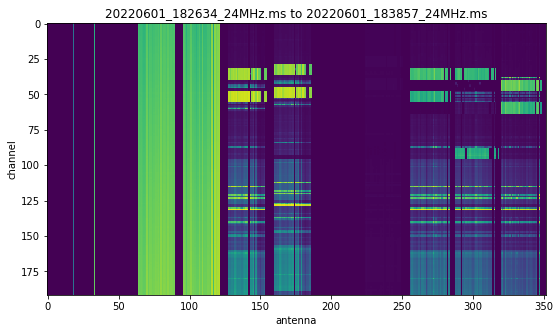

In [27]:
writergif = animation.PillowWriter(fps=1)
fig, ax = plt.subplots(1, 1, figsize=(12,5))

def f(fn, pol=0):
    tb = read_mstar(fn)
    data = get_data(tb, pol=pol, show=False)
    return data

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for fn in filelist:
    ax.set_xlabel('antenna')
    ax.set_ylabel('channel')
    ax.set_title(f"{os.path.basename(filelist[0])} to {os.path.basename(filelist[-1])}")
    data = ax.imshow(f(fn), animated=True)

    ims.append([data])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True)

ani.save('tmp2.gif', writer=writergif)

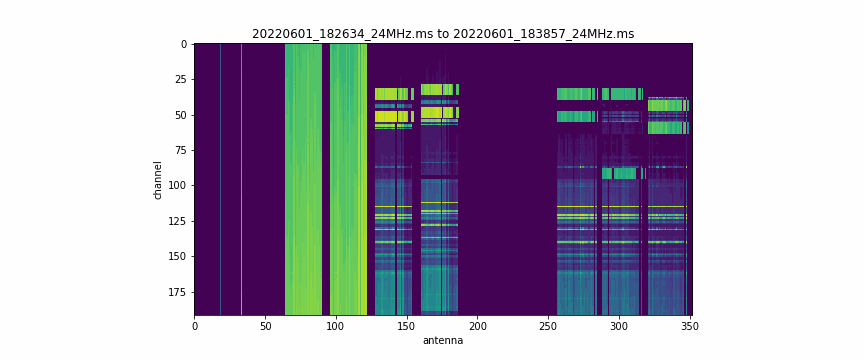

In [28]:
Image('tmp2.gif')

/home/ubuntu/data/slow/20220601_183616_24MHz.ms
Successful readonly open of default-locked table /home/ubuntu/data/slow/20220601_183616_24MHz.ms: 22 columns, 62128 rows
(352, 192, 4) (352,)


Text(0,0.5,'channel')

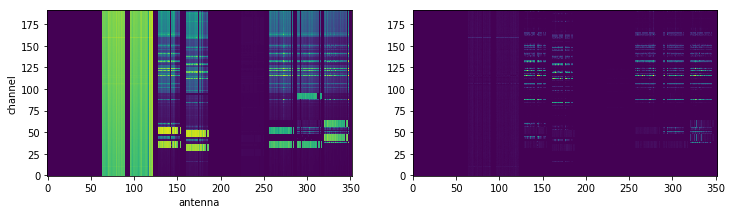

In [55]:
fn = filelist[58]
print(fn)
tb = casacore.tables.table(fn)
tb2 = tb.query('ANTENNA1=ANTENNA2')
data = np.abs(tb2.getcol("DATA"))
times = tb2.getcol("TIME")
print(data.shape, times.shape)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,5))
im = ax0.imshow(data[..., 0].transpose(), origin='lower', interpolation='nearest', animated=True)
im = ax1.imshow(data[..., 1].transpose(), origin='lower', interpolation='nearest', animated=True)
ax0.set_xlabel('antenna')
ax0.set_ylabel('channel')

In [11]:
mapping.correlator_to_antname(200)

'LWA-112'